In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import glob 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import torch

C:\Users\hy138\AppData\Local\Temp\ipykernel_19356\3508959855.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def extract_topic_name(flight_name, file_name):
    topic_name = file_name.split(flight_name)
    topic_name =  topic_name[1].strip("-") if len(topic_name)>1 else ""
    topic_name = topic_name.split(".csv")[0]
    return topic_name

In [3]:
def read_data(full_path):
    df_tmp = pd.read_csv(full_path,on_bad_lines="skip")
    df_tmp = df_tmp.rename(columns={"%time": "timestamp"})
    
    df_tmp["timestamp"] = pd.to_datetime(df_tmp["timestamp"], unit="ns")
    df_tmp.set_index("timestamp", inplace=True) 
    return df_tmp


In [4]:
data_path = "./data/processed/"

In [5]:
unused_topic_list = ["diagnostics", "emergency_responder-traj_file","mavlink-from","mavros-state",
                    "global_position",
                     "local_position", 
                     "mavctrl-rpy",
                     "mavros-battery", "field_raw",
                     "mavros-imu-mag", "mavros-mission-reached",
                     "mavros-rc",
                      "setpoint_raw","mavros-imu-data_raw"]

unused_column_list = ["field.header.seq", "field.header.stamp", "field.header.frame_id", 
                      "field.commanded", "field.variance", "%time","field.x","field.twist.angular.x","field.twist.angular.y","field.twist.angular.z",
                      'field.orientation_covariance0',
       'field.orientation_covariance1',
       'field.orientation_covariance2',
       'field.orientation_covariance3',
       'field.orientation_covariance4',
       'field.orientation_covariance5',
       'field.orientation_covariance6',
       'field.orientation_covariance7',
       'field.orientation_covariance8',

       'field.angular_velocity_covariance0',
       'field.angular_velocity_covariance1',
       'field.angular_velocity_covariance2',
       'field.angular_velocity_covariance3',
       'field.angular_velocity_covariance4',
       'field.angular_velocity_covariance5',
       'field.angular_velocity_covariance6',
       'field.angular_velocity_covariance7',
       'field.angular_velocity_covariance8',

       'field.linear_acceleration_covariance0',
       'field.linear_acceleration_covariance1',
       'field.linear_acceleration_covariance2',
       'field.linear_acceleration_covariance3',
       'field.linear_acceleration_covariance4',
       'field.linear_acceleration_covariance5',
       'field.linear_acceleration_covariance6',
       'field.linear_acceleration_covariance7',
       'field.linear_acceleration_covariance8',
       "field.coordinate_frame","field.source"]

In [6]:
print(os.getcwd())
print(os.listdir())

c:\Users\hy138\Desktop\UAV
['.vscode', 'best_model.pth', 'BiLSTM.ipynb', 'BiLSTMs.ipynb', 'CNN1D.ipynb', 'CNN1Ds.ipynb', 'data', 'LSTM.ipynb', 'LSTMAutoEncoder.ipynb', 'LSTMs.ipynb', 'Yeni klasör']


In [7]:
time_dict = {}
flight_topic_list = []
topic_list = []
all_columns = []
df_dict = {}
failure_status_dict = {}

In [8]:
print(topic_list)

[]


In [9]:
for i,flight in enumerate(glob.glob(data_path+"*")):
    
    flight_name = os.path.basename(flight)
    
    if "no_ground_truth" in flight_name:
        continue
    if "no_failure" in flight_name:
            continue
    # This folder has not path-dev csv file
    if "carbonZ_2018-09-11-15-06-34_3_rudder_left_failure" in flight_name:
        continue
    print(flight_name)

    if flight_name not in flight_topic_list:
        flight_topic_list.append(flight_name)
    

    df_failure = None
    failure_duration_start = pd.Timestamp('1970-01-01')
    failure_duration_finish = pd.Timestamp('1970-01-01')

    dfs = list()
    for i , file in enumerate(glob.glob(os.path.join(data_path,flight_name,"*.csv"))):
        
        if any(x in file for x in unused_topic_list):
            continue
        

        if "failure_status" in os.path.basename(file):
            file_name = os.path.basename(file)
            
            df = read_data(file)
            topic_name = extract_topic_name(flight_name,file_name)

            
            failure_duration_start = min(df.index)
            failure_duration_end = max(df.index)

            failure_status_dict[flight_name] = (failure_duration_start,failure_duration_end)

            continue
        
        file_name = os.path.basename(file)

        df = read_data(file)
        topic_name = extract_topic_name(flight_name,file_name)
        for col in unused_column_list:
            if col in df.columns:
                df.drop(col,axis=1,inplace=True)
        new_columns = list(map(lambda x: f"{topic_name}.{x.replace('field.', '')}", df.columns))
        df = df.set_axis(new_columns, axis=1)
       
     
        
        dfs.append(df)

   
    df_dict[flight_name] = dfs

    

carbonZ_2018-07-18-15-53-31_1_engine_failure
carbonZ_2018-07-18-15-53-31_2_engine_failure
carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj
carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-39-00_1_engine_failure
carbonZ_2018-07-30-16-39-00_2_engine_failure
carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj
carbonZ_2018-09-11-11-56-30_engine_failure
carbonZ_2018-09-11-14-22-07_1_engine_failure
carbonZ_2018-09-11-14-22-07_2_engine_failure
carbonZ_2018-09-11-14-41-51_elevator_failure
carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure
carbonZ_2018-09-11-15-05-11_1_elevator_failure
carbonZ_2018-09-11-15-06-34_1_rudder_right_failure
carbonZ_2018-09-11-15-06-34_2_rudder_right_failure
carbonZ_2018-09-11-17-27-13

In [10]:
len(df_dict["carbonZ_2018-07-18-15-53-31_1_engine_failure"])

13

In [11]:
len(df_dict["carbonZ_2018-07-18-15-53-31_1_engine_failure"][0]),df_dict["carbonZ_2018-07-18-15-53-31_1_engine_failure"][0].isna().sum()

(6619,
 mavctrl-path_dev.y    0
 mavctrl-path_dev.z    0
 dtype: int64)

In [12]:
failure_status_dict

{'carbonZ_2018-07-18-15-53-31_1_engine_failure': (Timestamp('2018-07-18 19:58:47.129305993'),
  Timestamp('2018-07-18 19:59:03.134074845')),
 'carbonZ_2018-07-18-15-53-31_2_engine_failure': (Timestamp('2018-07-18 20:01:44.729304590'),
  Timestamp('2018-07-18 20:01:59.928010526')),
 'carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj': (Timestamp('2018-07-18 20:32:26.878396465'),
  Timestamp('2018-07-18 20:32:42.672828037')),
 'carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj': (Timestamp('2018-07-18 20:46:37.888445250'),
  Timestamp('2018-07-18 20:46:54.288954056')),
 'carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj': (Timestamp('2018-07-21 00:35:22.170194'),
  Timestamp('2018-07-21 00:35:41.166058768')),
 'carbonZ_2018-07-30-16-39-00_1_engine_failure': (Timestamp('2018-07-21 01:00:21.380769776'),
  Timestamp('2018-07-21 01:00:36.175981200')),
 'carbonZ_2018-07-30-16-39-00_2_engine_failure': (Timestamp('2018-07-21 01:04:00.575490608'),
  Timestamp('2018-07-21 0

In [13]:
for key, df in df_dict.items():
    print(key)
    print(len(df))

carbonZ_2018-07-18-15-53-31_1_engine_failure
13
carbonZ_2018-07-18-15-53-31_2_engine_failure
13
carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj
13
carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-16-39-00_1_engine_failure
13
carbonZ_2018-07-30-16-39-00_2_engine_failure
13
carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj
13
carbonZ_2018-09-11-11-56-30_engine_failure
13
carbonZ_2018-09-11-14-22-07_1_engine_failure
13
carbonZ_2018-09-11-14-22-07_2_engine_failure
13
carbonZ_2018-09-11-14-41-51_elevator_failure
13
carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure
13
carbonZ_2018-09-11-15-05-11_1_elevator_failure
13
carbonZ_2018-09-11-15-06-34_1_rudder_right_failure
13
carbonZ_2018-09-11-15-06

In [14]:
for key, data in df_dict.items():
    if "rudder_zero__left_aileron_failure" in key:
        

        df_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero_failure"] = df_dict['carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure'].copy()
 
 

        df_dict["carbonZ_2018-09-11-17-27-13_1_left_aileron_failure"] = df_dict['carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure'].copy()

   

        del df_dict['carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure']


        break
 


In [15]:
for key, df in df_dict.items():
    print(key)
    print(len(df))

carbonZ_2018-07-18-15-53-31_1_engine_failure
13
carbonZ_2018-07-18-15-53-31_2_engine_failure
13
carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj
13
carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-16-39-00_1_engine_failure
13
carbonZ_2018-07-30-16-39-00_2_engine_failure
13
carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj
13
carbonZ_2018-09-11-11-56-30_engine_failure
13
carbonZ_2018-09-11-14-22-07_1_engine_failure
13
carbonZ_2018-09-11-14-22-07_2_engine_failure
13
carbonZ_2018-09-11-14-41-51_elevator_failure
13
carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure
13
carbonZ_2018-09-11-15-05-11_1_elevator_failure
13
carbonZ_2018-09-11-15-06-34_1_rudder_right_failure
13
carbonZ_2018-09-11-15-06

In [16]:
for key, data in failure_status_dict.items():
    if "rudder_zero__left_aileron_failure" in key:
        failure_status_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero_failure"] = failure_status_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure"]
        failure_status_dict["carbonZ_2018-09-11-17-27-13_1_left_aileron_failure"] = failure_status_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure"]
        del failure_status_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure"]
        break

In [17]:
df_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero_failure"][1].columns

Index(['mavros-imu-atm_pressure.fluid_pressure'], dtype='object')

In [18]:
df_dict["carbonZ_2018-07-18-15-53-31_1_engine_failure"][0]

mavctrl-path_dev.y  mavctrl-path_dev.z
timestamp                                                            
2018-07-18 19:56:50.820860792          141.284886           14.438259
2018-07-18 19:56:50.840917944          141.284886           14.438259
2018-07-18 19:56:50.861388914          141.284886           14.438259
2018-07-18 19:56:50.880812090          141.284886           14.438259
2018-07-18 19:56:50.901712334          144.798264           14.394005
...                                           ...                 ...
2018-07-18 19:59:03.108804965            8.337481           21.670137
2018-07-18 19:59:03.130722624            8.337481           21.670137
2018-07-18 19:59:03.149511356            8.337481           21.670137
2018-07-18 19:59:03.171009244            8.337481           21.670137
2018-07-18 19:59:03.190838957            8.337481           21.670137

[6619 rows x 2 columns]

In [19]:
flight_topic_list.append("carbonZ_2018-09-11-17-27-13_1_rudder_zero_failure")
flight_topic_list.append("carbonZ_2018-09-11-17-27-13_1_left_aileron_failure")
flight_topic_list.remove("carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure")


In [20]:
len(flight_topic_list)

36

In [21]:
failure_status_dict["carbonZ_2018-07-18-15-53-31_1_engine_failure"]

(Timestamp('2018-07-18 19:58:47.129305993'),
 Timestamp('2018-07-18 19:59:03.134074845'))

In [22]:
df = df_dict["carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure"]
df

[                               mavctrl-path_dev.y  mavctrl-path_dev.z
 timestamp                                                            
 2018-09-11 18:55:44.748852696          226.349940          -16.530594
 2018-09-11 18:55:44.768693912          226.349940          -16.530594
 2018-09-11 18:55:44.793884088          207.499653          -16.530594
 2018-09-11 18:55:44.809683352          207.499366          -16.530594
 2018-09-11 18:55:44.831660792          207.499366          -16.530594
 ...                                           ...                 ...
 2018-09-11 18:59:38.029159576            5.033987            3.622774
 2018-09-11 18:59:38.049874936            5.033987            3.622774
 2018-09-11 18:59:38.073666904            5.033987            3.622774
 2018-09-11 18:59:38.089277368            4.698973            4.732197
 2018-09-11 18:59:38.109449304            4.698973            4.732197
 
 [11669 rows x 2 columns],
                                mavros-imu-atm_p

Failure Status:
    
    Engine     = 1
    Rudder     = 2
    Aileron    = 3
    Elevator   = 4

In [23]:
def add_failure(flight_name,df_failure,failure_duration_start,failure_duration_end):
    if "engine" in flight_name:
        failure_status = [
        1 if (x > failure_duration_start and x < failure_duration_end) else 0 
        for x in df_failure.index
                ]
    elif "rudder" in flight_name:
        failure_status = [
        2 if (x > failure_duration_start and x < failure_duration_end) else 0 
        for x in df_failure.index
                ]
    elif "aileron" in flight_name:
        failure_status = [
        3 if (x > failure_duration_start and x < failure_duration_end) else 0 
        for x in df_failure.index
                ]
    elif "elevator" in flight_name:
        failure_status = [
        4 if (x > failure_duration_start and x < failure_duration_end) else 0 
        for x in df_failure.index
                ]
        
    df_failure["failure_status"] = failure_status
        
    return df_failure

In [24]:
flight_topic_list

['carbonZ_2018-07-18-15-53-31_1_engine_failure',
 'carbonZ_2018-07-18-15-53-31_2_engine_failure',
 'carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj',
 'carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj',
 'carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj',
 'carbonZ_2018-07-30-16-39-00_1_engine_failure',
 'carbonZ_2018-07-30-16-39-00_2_engine_failure',
 'carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj',
 'carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj',
 'carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj',
 'carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj',
 'carbonZ_2018-09-11-11-56-30_engine_failure',
 'carbonZ_2018-09-11-14-22-07_1_engine_failure',
 'carbonZ_2018-09-11-14-22-07_2_engine_failure',
 'carbonZ_2018-09-11-14-41-51_elevator_failure',
 'carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure',
 'carbonZ_2018-09-11-15-05-11_1_elevator_failure',
 'carbonZ_2018-09-11-15-06-34_1_rudder_right_failure',
 'carb

In [25]:
for flight_name in flight_topic_list:
    print(flight_name)
    dfs = df_dict[flight_name] 
    
    start_time = min(min(dfs[0].index),min(dfs[1].index),min(dfs[2].index),min(dfs[3].index),min(dfs[4].index),min(dfs[5].index),min(dfs[6].index),min(dfs[7].index),min(dfs[8].index),min(dfs[9].index),min(dfs[10].index),min(dfs[11].index),min(dfs[12].index))
    end_time = max(max(dfs[0].index),max(dfs[1].index),max(dfs[2].index),max(dfs[3].index),max(dfs[4].index),max(dfs[5].index),max(dfs[6].index),max(dfs[7].index),max(dfs[8].index),max(dfs[9].index),max(dfs[10].index),max(dfs[11].index),max(dfs[12].index))
    
    time_index = pd.date_range(start=start_time, end=end_time, freq="200ms")  
    data = [0] * len(time_index)

    df_failure = pd.DataFrame(data, index=time_index, columns=["failure_status"])

    failure_duration_start = failure_status_dict[flight_name][0]
    failure_duration_end   = failure_status_dict[flight_name][1]
    
    
    df_dict[flight_name].append(add_failure(flight_name,df_failure,failure_duration_start,failure_duration_end))

carbonZ_2018-07-18-15-53-31_1_engine_failure
carbonZ_2018-07-18-15-53-31_2_engine_failure
carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj
carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-39-00_1_engine_failure
carbonZ_2018-07-30-16-39-00_2_engine_failure
carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj
carbonZ_2018-09-11-11-56-30_engine_failure
carbonZ_2018-09-11-14-22-07_1_engine_failure
carbonZ_2018-09-11-14-22-07_2_engine_failure
carbonZ_2018-09-11-14-41-51_elevator_failure
carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure
carbonZ_2018-09-11-15-05-11_1_elevator_failure
carbonZ_2018-09-11-15-06-34_1_rudder_right_failure
carbonZ_2018-09-11-15-06-34_2_rudder_right_failure
carbonZ_2018-09-11-17-27-13

In [26]:
df = df_dict["carbonZ_2018-09-11-17-27-13_1_left_aileron_failure"]
df[12].iloc[: , :]

mavros-wind_estimation.twist.linear.x  \
timestamp                                                              
2018-09-11 21:34:19.188548395                               0.360470   
2018-09-11 21:34:19.566847897                               0.352583   
2018-09-11 21:34:19.954091484                               0.345375   
2018-09-11 21:34:20.421941571                               0.328750   
2018-09-11 21:34:20.868431200                               0.321009   
...                                                              ...   
2018-09-11 21:36:40.589048991                              -0.256345   
2018-09-11 21:36:40.936268682                              -0.255210   
2018-09-11 21:36:41.422716742                              -0.253657   
2018-09-11 21:36:41.785506158                              -0.252744   
2018-09-11 21:36:42.286168071                              -0.252200   

                               mavros-wind_estimation.twist.linear.y  \
timestamp                                                              
2018-09-11 21:34:19.188548395                               1.439026   
2018-09-11 21:34:19.566847897                               1.463511   
2018-09-11 21:34:19.954091484                               1.496819   
2018-09-11 21:34:20.421941571                               1.548180   
2018-09-11 21:34:20.868431200                               1.588851   
...                                                              ...   
2018-09-11 21:36:40.589048991                               2.252147   
2018-09-11 21:36:40.936268682                               2.252631   
2018-09-11 21:36:41.422716742                               2.253724   
2018-09-11 21:36:41.785506158                               2.256600   
2018-09-11 21:36:42.286168071                               2.260911   

                               mavros-wind_estimation.twist.linear.z  
timestamp                                                             
2018-09-11 21:34:19.188548395                                    0.0  
2018-09-11 21:34:19.566847897                                    0.0  
2018-09-11 21:34:19.954091484                                    0.0  
2018-09-11 21:34:20.421941571                                    0.0  
2018-09-11 21:34:20.868431200                                    0.0  
...                                                              ...  
2018-09-11 21:36:40.589048991                                    0.0  
2018-09-11 21:36:40.936268682                                    0.0  
2018-09-11 21:36:41.422716742                                    0.0  
2018-09-11 21:36:41.785506158                                    0.0  
2018-09-11 21:36:42.286168071                                    0.0  

[311 rows x 3 columns]

In [27]:
df = df_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero_failure"]
df[12]


mavros-wind_estimation.twist.linear.x  \
timestamp                                                              
2018-09-11 21:34:19.188548395                               0.360470   
2018-09-11 21:34:19.566847897                               0.352583   
2018-09-11 21:34:19.954091484                               0.345375   
2018-09-11 21:34:20.421941571                               0.328750   
2018-09-11 21:34:20.868431200                               0.321009   
...                                                              ...   
2018-09-11 21:36:40.589048991                              -0.256345   
2018-09-11 21:36:40.936268682                              -0.255210   
2018-09-11 21:36:41.422716742                              -0.253657   
2018-09-11 21:36:41.785506158                              -0.252744   
2018-09-11 21:36:42.286168071                              -0.252200   

                               mavros-wind_estimation.twist.linear.y  \
timestamp                                                              
2018-09-11 21:34:19.188548395                               1.439026   
2018-09-11 21:34:19.566847897                               1.463511   
2018-09-11 21:34:19.954091484                               1.496819   
2018-09-11 21:34:20.421941571                               1.548180   
2018-09-11 21:34:20.868431200                               1.588851   
...                                                              ...   
2018-09-11 21:36:40.589048991                               2.252147   
2018-09-11 21:36:40.936268682                               2.252631   
2018-09-11 21:36:41.422716742                               2.253724   
2018-09-11 21:36:41.785506158                               2.256600   
2018-09-11 21:36:42.286168071                               2.260911   

                               mavros-wind_estimation.twist.linear.z  
timestamp                                                             
2018-09-11 21:34:19.188548395                                    0.0  
2018-09-11 21:34:19.566847897                                    0.0  
2018-09-11 21:34:19.954091484                                    0.0  
2018-09-11 21:34:20.421941571                                    0.0  
2018-09-11 21:34:20.868431200                                    0.0  
...                                                              ...  
2018-09-11 21:36:40.589048991                                    0.0  
2018-09-11 21:36:40.936268682                                    0.0  
2018-09-11 21:36:41.422716742                                    0.0  
2018-09-11 21:36:41.785506158                                    0.0  
2018-09-11 21:36:42.286168071                                    0.0  

[311 rows x 3 columns]

In [28]:
for key, df in df_dict.items():
    print(key)
    print(len(df))

carbonZ_2018-07-18-15-53-31_1_engine_failure
14
carbonZ_2018-07-18-15-53-31_2_engine_failure
14
carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj
14
carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj
14
carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj
14
carbonZ_2018-07-30-16-39-00_1_engine_failure
14
carbonZ_2018-07-30-16-39-00_2_engine_failure
14
carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj
14
carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj
14
carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj
14
carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj
14
carbonZ_2018-09-11-11-56-30_engine_failure
14
carbonZ_2018-09-11-14-22-07_1_engine_failure
14
carbonZ_2018-09-11-14-22-07_2_engine_failure
14
carbonZ_2018-09-11-14-41-51_elevator_failure
14
carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure
14
carbonZ_2018-09-11-15-05-11_1_elevator_failure
14
carbonZ_2018-09-11-15-06-34_1_rudder_right_failure
14
carbonZ_2018-09-11-15-06

Birleştirme:

In [29]:
df = df_dict["carbonZ_2018-07-18-15-53-31_1_engine_failure"][1]
df

mavros-imu-atm_pressure.fluid_pressure
timestamp                                                            
2018-07-18 19:56:50.883316762                            97310.498047
2018-07-18 19:56:50.958577559                            97310.498047
2018-07-18 19:56:51.062952770                            97329.193115
2018-07-18 19:56:51.153503583                            97341.693115
2018-07-18 19:56:51.245127118                            97329.223633
...                                                               ...
2018-07-18 19:59:02.784104260                            97410.662842
2018-07-18 19:59:02.886696084                            97414.984131
2018-07-18 19:59:02.954867820                            97414.984131
2018-07-18 19:59:03.072783613                            97418.975830
2018-07-18 19:59:03.128568663                            97418.975830

[1323 rows x 1 columns]

In [30]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

scaler = StandardScaler()

w_label = 66
s_label = 6

window_sizes = [661, 132, 32, 132, 247, 253, 253, 253, 247, 253, 27, 32, 27]
step_sizes =   [66, 13, 3, 13, 24, 25, 25, 25, 24, 25, 2, 3, 2]

x_arrays = [np.zeros((0, w, c)) for w, c in zip(window_sizes, [2, 1, 10, 1, 1, 4, 1, 1, 6, 1, 1, 6, 3])]
y = []

for key, data in df_dict.items():
    print(key)
    
    scaled_data = [pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index).dropna() for df in data[:-1]]
    labels_data = data[-1]

    len_label = len(labels_data)
    len_data = [len(df) for df in scaled_data]

    while all(len_d - w >= 0 for len_d, w in zip(len_data, window_sizes)):
        labels = labels_data[len_label - w_label : len_label].values
        len_label -= s_label

        slices = [df[len_d - w : len_d].values for df, len_d, w in zip(scaled_data, len_data, window_sizes)]
        reshaped_slices = [
            sl.reshape(-1, w, c) for sl, w, c in zip(slices, window_sizes, [2, 1, 10, 1, 1, 4, 1, 1, 6, 1, 1, 6, 3])
        ]
        len_data = [len_d - s for len_d, s in zip(len_data, step_sizes)]

        if 2 in labels:
            repeat_count = 4
        elif 3 in labels:
            repeat_count = 3
        elif 4 in labels:
            repeat_count = 5
        else:
            repeat_count = 1
        
        for _ in range(repeat_count):
            for i, sl in enumerate(reshaped_slices):
                x_arrays[i] = np.vstack((x_arrays[i], sl))
            y.append(labels)


carbonZ_2018-07-18-15-53-31_1_engine_failure
carbonZ_2018-07-18-15-53-31_2_engine_failure
carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj
carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-39-00_1_engine_failure
carbonZ_2018-07-30-16-39-00_2_engine_failure
carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj
carbonZ_2018-09-11-11-56-30_engine_failure
carbonZ_2018-09-11-14-22-07_1_engine_failure
carbonZ_2018-09-11-14-22-07_2_engine_failure
carbonZ_2018-09-11-14-41-51_elevator_failure
carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure
carbonZ_2018-09-11-15-05-11_1_elevator_failure
carbonZ_2018-09-11-15-06-34_1_rudder_right_failure
carbonZ_2018-09-11-15-06-34_2_rudder_right_failure
carbonZ_2018-09-11-17-27-13

In [31]:
shapes = [x.shape for x in x_arrays]
shapes

[(3666, 661, 2),
 (3666, 132, 1),
 (3666, 32, 10),
 (3666, 132, 1),
 (3666, 247, 1),
 (3666, 253, 4),
 (3666, 253, 1),
 (3666, 253, 1),
 (3666, 247, 6),
 (3666, 253, 1),
 (3666, 27, 1),
 (3666, 32, 6),
 (3666, 27, 3)]

In [32]:
x_arrays[9][495][-1]

array([-1.2548107])

In [33]:
len(y)

3666

In [34]:
y = np.array(y)
y_ = np.array([max(m) for m in y])
y_.shape,y.shape

((3666, 1), (3666, 66, 1))

In [35]:
import random 

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


set_seed(42)

In [36]:
idx = np.where(y_ == 0)[0]
ida = np.where(y_ != 0)[0]

x_arrays_no_failure = [x_arrays[i][idx] for i in range(13)]
x_arrays_failure = [x_arrays[i][ida] for i in range(13)]


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class CustomDataset(Dataset):
    def __init__(self, x_arrays, y):
        self.x0 = torch.tensor(x_arrays[0], dtype=torch.float32)
        self.x1 = torch.tensor(x_arrays[1], dtype=torch.float32)
        self.x2 = torch.tensor(x_arrays[2], dtype=torch.float32)
        self.x3 = torch.tensor(x_arrays[3], dtype=torch.float32)
        self.x4 = torch.tensor(x_arrays[4], dtype=torch.float32)
        self.x5 = torch.tensor(x_arrays[5], dtype=torch.float32)
        self.x6 = torch.tensor(x_arrays[6], dtype=torch.float32)
        self.x7 = torch.tensor(x_arrays[7], dtype=torch.float32)
        self.x8 = torch.tensor(x_arrays[8], dtype=torch.float32)
        self.x9 = torch.tensor(x_arrays[9], dtype=torch.float32)
        self.x10 = torch.tensor(x_arrays[10], dtype=torch.float32)
        self.x11 = torch.tensor(x_arrays[11], dtype=torch.float32)
        self.x12 = torch.tensor(x_arrays[12], dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long).squeeze()

    def __len__(self):
        return len(self.y)
    
    def getInputShapes(self):
        return [x_arrays[i].shape for i in range(13)] 

    def __getitem__(self, idx):
        return (
            self.x0[idx], self.x1[idx], self.x2[idx], self.x3[idx], self.x4[idx],
            self.x5[idx], self.x6[idx], self.x7[idx], self.x8[idx], self.x9[idx],
            self.x10[idx], self.x11[idx], self.x12[idx], self.y[idx]
        )


dataset_no_failure = CustomDataset(x_arrays_no_failure, y_[idx])

train_size = int(0.8 * len(dataset_no_failure))
test_size = len(dataset_no_failure) - train_size
train_normal_dataset, test_normal_dataset = random_split(dataset_no_failure, [train_size, test_size])


batch_size = 16
train_normal_dataloader = DataLoader(train_normal_dataset, batch_size=batch_size, shuffle=True)
test_normal_dataloader = DataLoader(test_normal_dataset, batch_size=batch_size, shuffle=False)

# Example usage
for batch in train_normal_dataloader:
    (
        x0_batch, x1_batch, x2_batch, x3_batch, x4_batch, 
        x5_batch, x6_batch, x7_batch, x8_batch, x9_batch, 
        x10_batch, x11_batch, x12_batch, y_batch
    ) = batch
    print("Train batch shapes:", x0_batch.shape, x1_batch.shape, x2_batch.shape, x3_batch.shape, 
          x4_batch.shape, x5_batch.shape, x6_batch.shape, x7_batch.shape, x8_batch.shape, 
          x9_batch.shape, x10_batch.shape, x11_batch.shape, x12_batch.shape, y_batch.shape)
    break

for batch in test_normal_dataloader:
    (
        x0_batch, x1_batch, x2_batch, x3_batch, x4_batch, 
        x5_batch, x6_batch, x7_batch, x8_batch, x9_batch, 
        x10_batch, x11_batch, x12_batch, y_batch
    ) = batch
    print("Test batch shapes:", x0_batch.shape, x1_batch.shape, x2_batch.shape, x3_batch.shape, 
          x4_batch.shape, x5_batch.shape, x6_batch.shape, x7_batch.shape, x8_batch.shape, 
          x9_batch.shape, x10_batch.shape, x11_batch.shape, x12_batch.shape, y_batch.shape)
    break


NameError: name 'x_arrays_no_failure' is not defined

In [78]:
dataset_failure = CustomDataset(x_arrays_failure, y_[ida])


test_failure_dataset,_ = random_split(dataset_failure, [len(dataset_failure), 0])

batch_size = 32

test_failure_dataloader = DataLoader(test_failure_dataset, batch_size=batch_size, shuffle=False)



for batch in test_failure_dataloader:
    (
        x0_batch, x1_batch, x2_batch, x3_batch, x4_batch, 
        x5_batch, x6_batch, x7_batch, x8_batch, x9_batch, 
        x10_batch, x11_batch, x12_batch, y_batch
    ) = batch
    print("Test batch shapes:", x0_batch.shape, x1_batch.shape, x2_batch.shape, x3_batch.shape, 
          x4_batch.shape, x5_batch.shape, x6_batch.shape, x7_batch.shape, x8_batch.shape, 
          x9_batch.shape, x10_batch.shape, x11_batch.shape, x12_batch.shape, y_batch.shape)
    break


Test batch shapes: torch.Size([32, 661, 2]) torch.Size([32, 132, 1]) torch.Size([32, 32, 10]) torch.Size([32, 132, 1]) torch.Size([32, 247, 1]) torch.Size([32, 253, 4]) torch.Size([32, 253, 1]) torch.Size([32, 253, 1]) torch.Size([32, 247, 6]) torch.Size([32, 253, 1]) torch.Size([32, 27, 1]) torch.Size([32, 32, 6]) torch.Size([32, 27, 3]) torch.Size([32])


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [68]:
import torch
import torch.nn as nn

class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim):
        super(Encoder, self).__init__()

        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = [3*n for n in embedding_dim]

        self.rnn1_layers = nn.ModuleList([
            nn.LSTM(
                input_size=n_features[_],
                hidden_size=self.hidden_dim[_],
                num_layers=1,
                batch_first=True
            )
            for _ in range(13)
        ])
        
        self.rnn2_layers = nn.ModuleList([
            nn.LSTM(
                input_size=self.hidden_dim[_],
                hidden_size=self.embedding_dim[_],
                num_layers=1,
                batch_first=True
            )
            for _ in range(13)
        ])

    def forward(self, inputs):
        hidden_states = []

        for i, x in enumerate(inputs):
            batch_size = x.shape[0]

            x, (_, _) = self.rnn1_layers[i](x)

            x, (hidden_n, _) = self.rnn2_layers[i](x)
   
            hidden_n = hidden_n.reshape((batch_size, self.embedding_dim[i]))
        
            hidden_states.append(hidden_n)
           

        
        return hidden_states

In [41]:
class Decoder(nn.Module):
    def __init__(self, seq_len, n_features, input_dim):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim = [n*3 for n in input_dim]
        self.n_features = n_features

        self.rnn1_layers = nn.ModuleList([
            nn.LSTM(
                input_size=input_dim[_],
                hidden_size=input_dim[_],
                num_layers=1,
                batch_first=True
                )
                for _ in range(13)
        ])

        self.rnn2_layers = nn.ModuleList([
            nn.LSTM(
                input_size=input_dim[_],
                hidden_size=self.hidden_dim[_],
                num_layers=1,
                batch_first=True
                )
                for _ in range(13)
        ])

        self.output_layers = nn.ModuleList([
            nn.Linear(self.hidden_dim[_], n_features[_]) 
            for _ in range(13)
        ])


    def forward(self,inputs):
        outputs = []
        
        for i, x in enumerate(inputs):
            batch_size = x.shape[0]
       
            x = x.unsqueeze(1)
          
            x = x.repeat(1, self.seq_len[i], 1)
        
            x = x.reshape((batch_size, self.seq_len[i],self.input_dim[i]))
            
            x, (_, _) = self.rnn1_layers[i](x)
        
            x, (_, _) = self.rnn2_layers[i](x)
     
      
            x = self.output_layers[i](x)
          
            outputs.append(x)
        return outputs
        


In [79]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    
    self.decoder = Decoder(seq_len, n_features, embedding_dim).to(device)
    

  def forward(self, inputs):
    x = self.encoder(inputs)
  
    x = self.decoder(x)
    
 
    return x

input_shapes = dataset_no_failure.getInputShapes()
seq_len = [input_shapes[x][1] for x in range(13)]
n_features = [input_shapes[x][2] for x in range(13)]

embedding_dim = [2, 1, 10, 1, 1, 4, 1, 1, 6, 1, 1, 6, 3]
model = RecurrentAutoencoder(seq_len, n_features, embedding_dim)
print(model)

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1_layers): ModuleList(
      (0): LSTM(2, 6, batch_first=True)
      (1): LSTM(1, 3, batch_first=True)
      (2): LSTM(10, 30, batch_first=True)
      (3-4): 2 x LSTM(1, 3, batch_first=True)
      (5): LSTM(4, 12, batch_first=True)
      (6-7): 2 x LSTM(1, 3, batch_first=True)
      (8): LSTM(6, 18, batch_first=True)
      (9-10): 2 x LSTM(1, 3, batch_first=True)
      (11): LSTM(6, 18, batch_first=True)
      (12): LSTM(3, 9, batch_first=True)
    )
    (rnn2_layers): ModuleList(
      (0): LSTM(6, 2, batch_first=True)
      (1): LSTM(3, 1, batch_first=True)
      (2): LSTM(30, 10, batch_first=True)
      (3-4): 2 x LSTM(3, 1, batch_first=True)
      (5): LSTM(12, 4, batch_first=True)
      (6-7): 2 x LSTM(3, 1, batch_first=True)
      (8): LSTM(18, 6, batch_first=True)
      (9-10): 2 x LSTM(3, 1, batch_first=True)
      (11): LSTM(18, 6, batch_first=True)
      (12): LSTM(9, 3, batch_first=True)
    )
  )
  (decoder): Decoder(
    

In [43]:
import torch

class ModelCheckpoint:
    def __init__(self, filepath, monitor='val_loss', mode='min'):
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best_score = None
        self.best_state_dict = None

        if mode == 'min':
            self.best_score = float('inf')
        else:
            self.best_score = float('-inf')

    def __call__(self, score, model_state_dict):
        if (self.mode == 'min' and score < self.best_score) or (self.mode == 'max' and score > self.best_score):
            print(f"Saving model with {self.monitor}: {score}")
            self.best_score = score
            self.best_state_dict = model_state_dict
            torch.save(model_state_dict, self.filepath)

    def get_best_state_dict(self):
        return self.best_state_dict

In [80]:
import torch.optim.lr_scheduler as lr_scheduler

optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)
criterion =  nn.L1Loss(reduction='mean').to(device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",patience=5,factor=0.1)
checkpoint = ModelCheckpoint(filepath='best_model.pth', monitor='val_loss', mode='min')

In [81]:
train_losses = []

val_losses = []


num_epochs = 100

for epoch in range(num_epochs):
   
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, batch in enumerate(train_normal_dataloader):
        optimizer.zero_grad()
     
        batch_device = [batch[i].to(device) for i in range(len(batch))]
        outputs = model(batch_device[:-1])
        
       
        losses = [criterion(output, input_batch) for output, input_batch in zip(outputs, batch_device[:-1])]
        
   
        loss = sum(losses)  
 
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
 
        if i % 10 == 9:  
            print(f"Epoch {epoch + 1}, Batch {i + 1}/{len(train_normal_dataloader)}, Training Loss: {running_loss / (i + 1):.4f}")
        
    train_epoch_loss = running_loss / len(train_normal_dataloader)


    train_losses.append(train_epoch_loss)


    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for batch_val in test_normal_dataloader:
            batch_val_device = [batch_val[i].to(device) for i in range(len(batch_val))]          
        
            outputs = model(batch_val_device[:-1])
            
            losses = [criterion(output, input_batch) for output, input_batch in zip(outputs,batch_val_device[:-1])]
            val_running_loss += sum(losses).item() 
            
    if scheduler is not None:
        scheduler.step(val_running_loss)

   
    val_epoch_loss = val_running_loss / len(test_normal_dataloader)


    val_losses.append(val_epoch_loss)
    
    checkpoint(val_epoch_loss, model)

    print(f"Epoch {epoch + 1}, Validation Loss: {val_epoch_loss:.4f}")

    if optimizer is not None:
        print(f"Epoch {epoch + 1}: Adam lr {optimizer.param_groups[0]['lr']:.4f}")

print("Training finished.")


Epoch 1, Batch 10/55, Training Loss: 8.7458
Epoch 1, Batch 20/55, Training Loss: 8.7116
Epoch 1, Batch 30/55, Training Loss: 8.7034
Epoch 1, Batch 40/55, Training Loss: 8.6648
Epoch 1, Batch 50/55, Training Loss: 8.5851
Saving model with val_loss: 8.264384303774152
Epoch 1, Validation Loss: 8.2644
Epoch 1: Adam lr 0.0008
Epoch 2, Batch 10/55, Training Loss: 8.1976
Epoch 2, Batch 20/55, Training Loss: 8.0791
Epoch 2, Batch 30/55, Training Loss: 8.0423
Epoch 2, Batch 40/55, Training Loss: 8.0358
Epoch 2, Batch 50/55, Training Loss: 7.9491
Saving model with val_loss: 7.609766687665667
Epoch 2, Validation Loss: 7.6098
Epoch 2: Adam lr 0.0008
Epoch 3, Batch 10/55, Training Loss: 7.5201
Epoch 3, Batch 20/55, Training Loss: 7.5384
Epoch 3, Batch 30/55, Training Loss: 7.4936
Epoch 3, Batch 40/55, Training Loss: 7.4787
Epoch 3, Batch 50/55, Training Loss: 7.4380
Saving model with val_loss: 7.258109944207328
Epoch 3, Validation Loss: 7.2581
Epoch 3: Adam lr 0.0008
Epoch 4, Batch 10/55, Training 

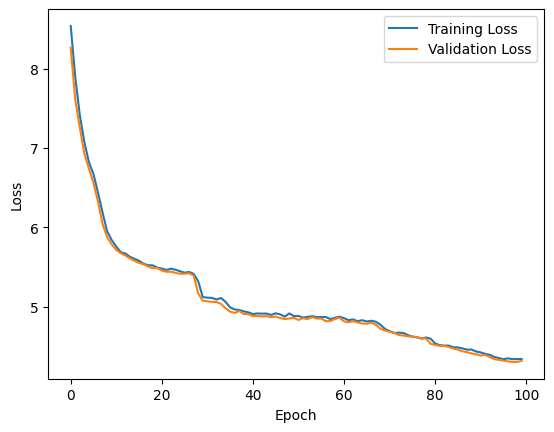

In [82]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [83]:
def predict(model, dataset):
    predictions = []
    val_running_loss = []  
    
    criterion = nn.L1Loss(reduction='mean').to(device)
    model = model.eval()
    
    with torch.no_grad():
        for batch in dataset:
            batch_device = [batch[i].to(device) for i in range(len(batch))]          
        
            outputs = model(batch_device[:-1])
            
            losses = [criterion(output, input_batch) for output, input_batch in zip(outputs,batch_device[:-1])]
        
            val_running_loss.append(sum(losses).item())  
            predictions.append(outputs)
            
    return val_running_loss,predictions

In [84]:
losses,_ = predict(model, train_normal_dataloader)
losses

[3.701693058013916,
 4.154150485992432,
 4.000933647155762,
 4.364588260650635,
 4.688483238220215,
 4.189266681671143,
 5.133608818054199,
 4.221818447113037,
 4.673403739929199,
 4.4023966789245605,
 4.4134979248046875,
 4.448869228363037,
 4.908363342285156,
 4.7385172843933105,
 4.1198930740356445,
 4.361809730529785,
 4.216553211212158,
 4.842381477355957,
 4.117143154144287,
 4.784433364868164,
 4.426699638366699,
 4.20898962020874,
 4.106109142303467,
 4.34757661819458,
 4.270040988922119,
 4.0490875244140625,
 4.474968910217285,
 4.313441276550293,
 4.549556732177734,
 4.293094635009766,
 4.3281474113464355,
 4.333283424377441,
 4.357339859008789,
 3.8271586894989014,
 4.228013515472412,
 4.145808219909668,
 3.8660330772399902,
 4.4156060218811035,
 4.441319942474365,
 4.171606540679932,
 4.551112651824951,
 4.066535949707031,
 4.38398551940918,
 4.141933917999268,
 4.297878742218018,
 4.359869003295898,
 4.045304298400879,
 4.600032329559326,
 4.487649440765381,
 4.30752468109

C:\Users\hy138\AppData\Local\Temp\ipykernel_19356\2408692264.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=5, kde=True);


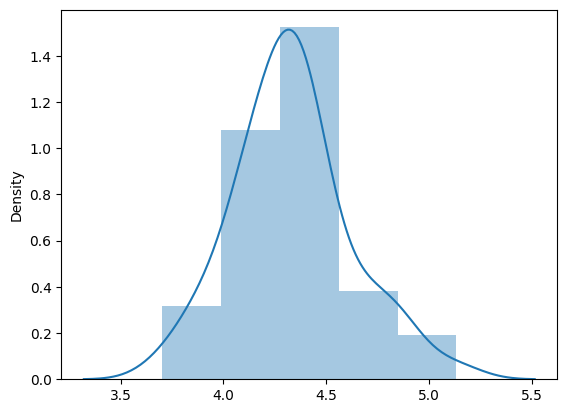

In [85]:
import seaborn as sns

sns.distplot(losses, bins=5, kde=True);

In [86]:
THRESHOLD = 5.25

correct = sum(l <= THRESHOLD for l in losses)
print(f'Correct normal predictions: {correct}/{len(train_normal_dataloader)}')

Correct normal predictions: 55/55


In [87]:
losses,pred = predict(model, test_failure_dataloader)
losses

[5.938560485839844,
 6.967165470123291,
 6.165987014770508,
 5.560605525970459,
 5.971349716186523,
 6.023166179656982,
 5.504388809204102,
 5.928843021392822,
 5.59817361831665,
 5.995528697967529,
 5.199514389038086,
 5.6784820556640625,
 5.9560065269470215,
 5.701961517333984,
 5.815758228302002,
 6.675841808319092,
 5.800827980041504,
 6.051544666290283,
 4.595968723297119,
 5.935244083404541,
 5.830099105834961,
 5.813174724578857,
 6.314094066619873,
 6.156538009643555,
 6.11442232131958,
 5.95396614074707,
 6.133221626281738,
 5.52697229385376,
 5.821997165679932,
 6.192488670349121,
 6.337097644805908,
 5.6345319747924805,
 6.587751865386963,
 5.4317426681518555,
 5.441920280456543,
 5.9287872314453125,
 5.742377758026123,
 5.489435195922852,
 5.62812614440918,
 5.718024253845215,
 5.763641834259033,
 6.2037858963012695,
 5.327611446380615,
 6.093420505523682,
 5.10677433013916,
 5.809418201446533,
 5.8908586502075195]

In [88]:
correct = sum(l > THRESHOLD for l in losses)
print(f'Correct failure predictions: {correct}/{len(test_failure_dataloader)}')

Correct failure predictions: 44/47


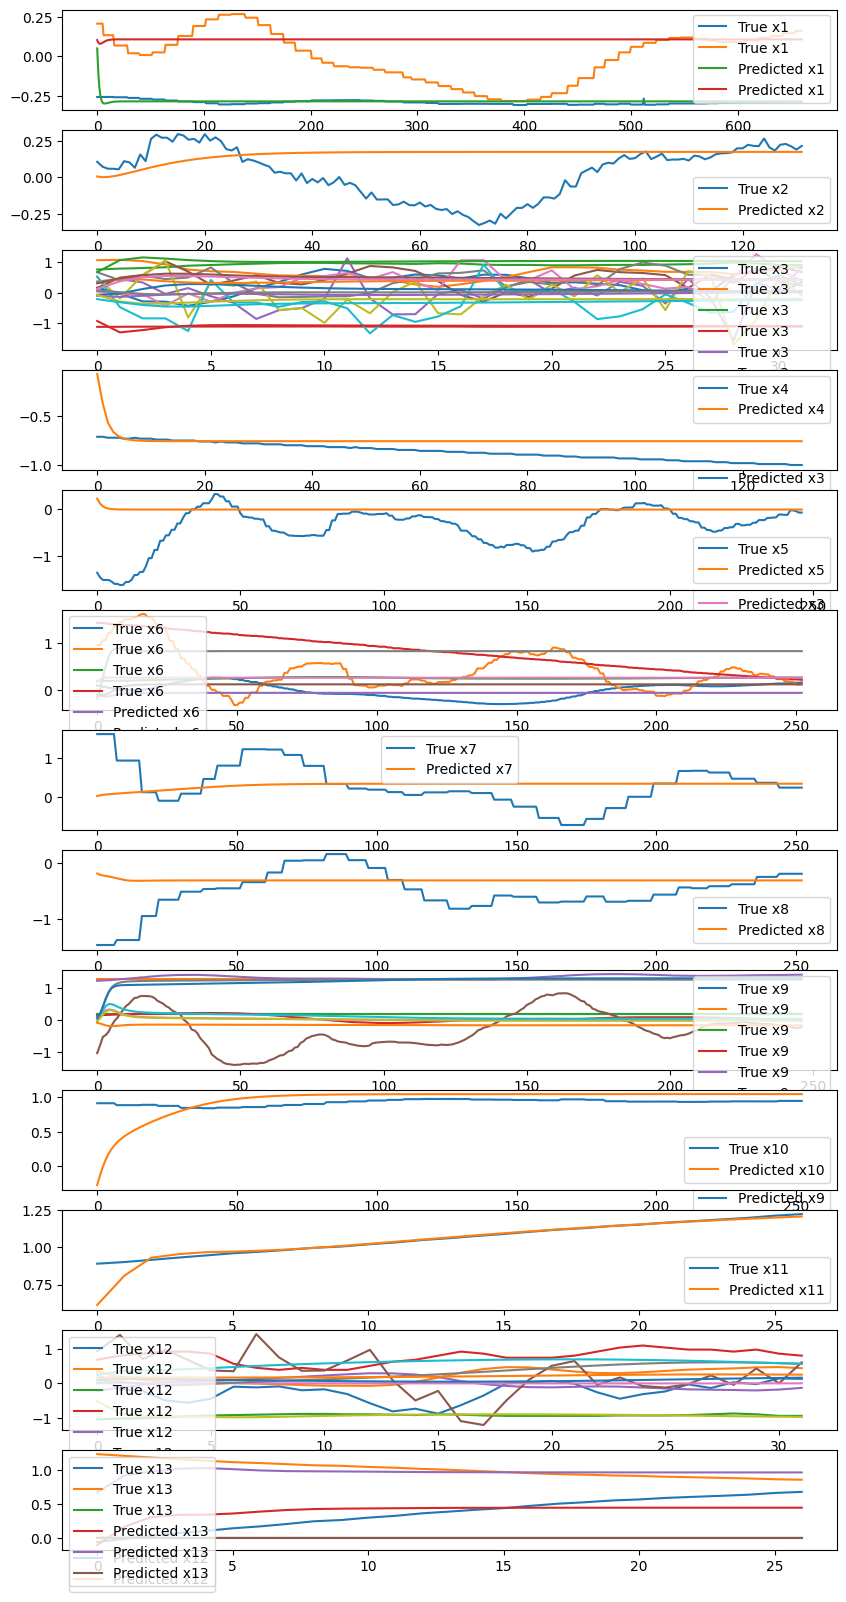

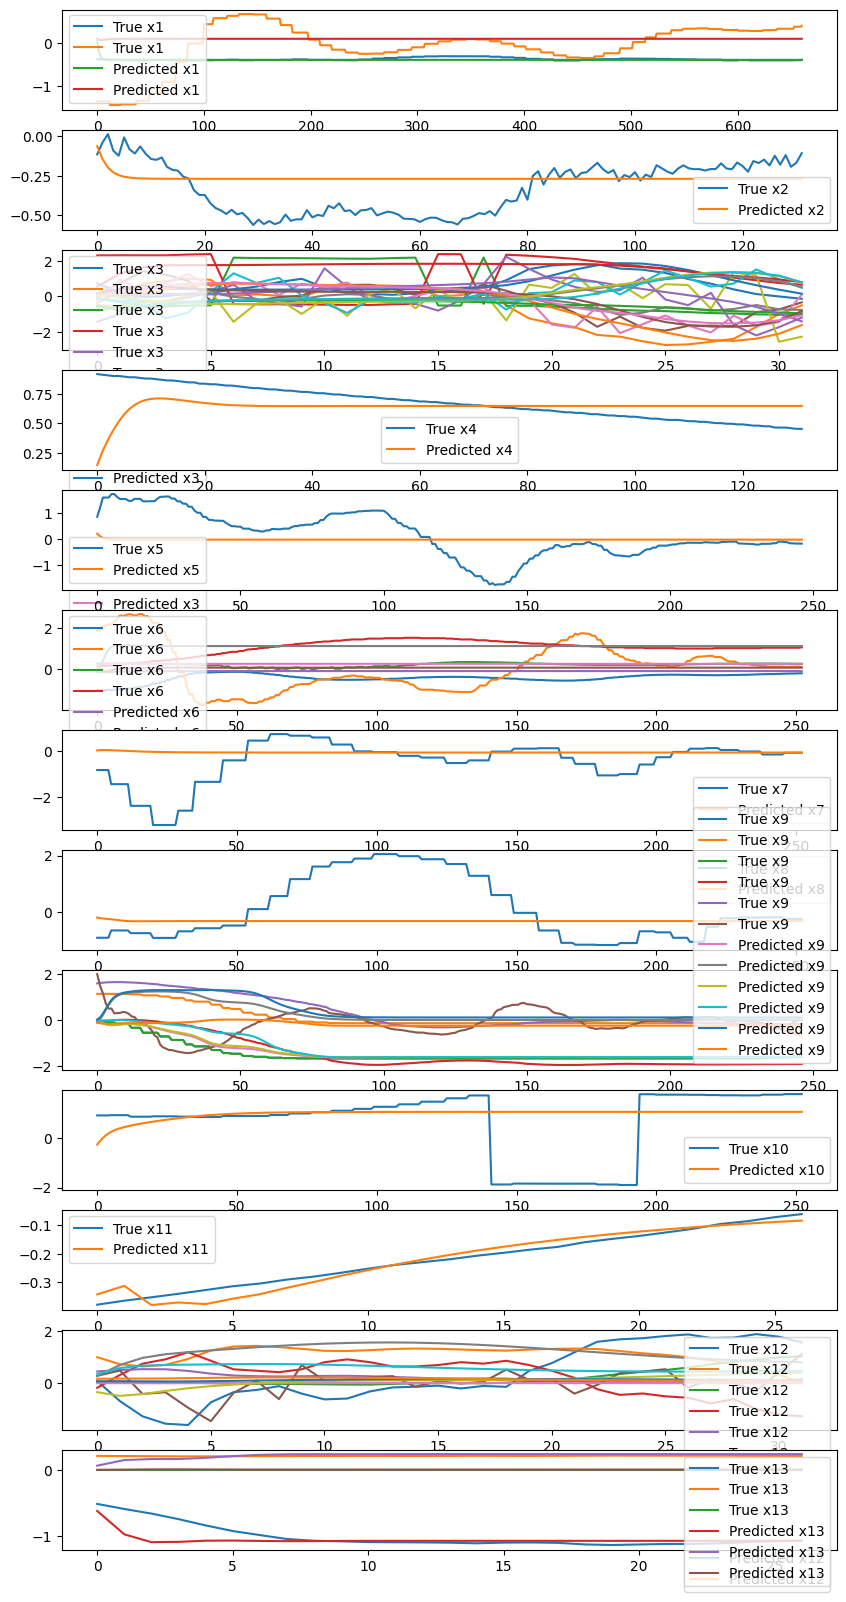

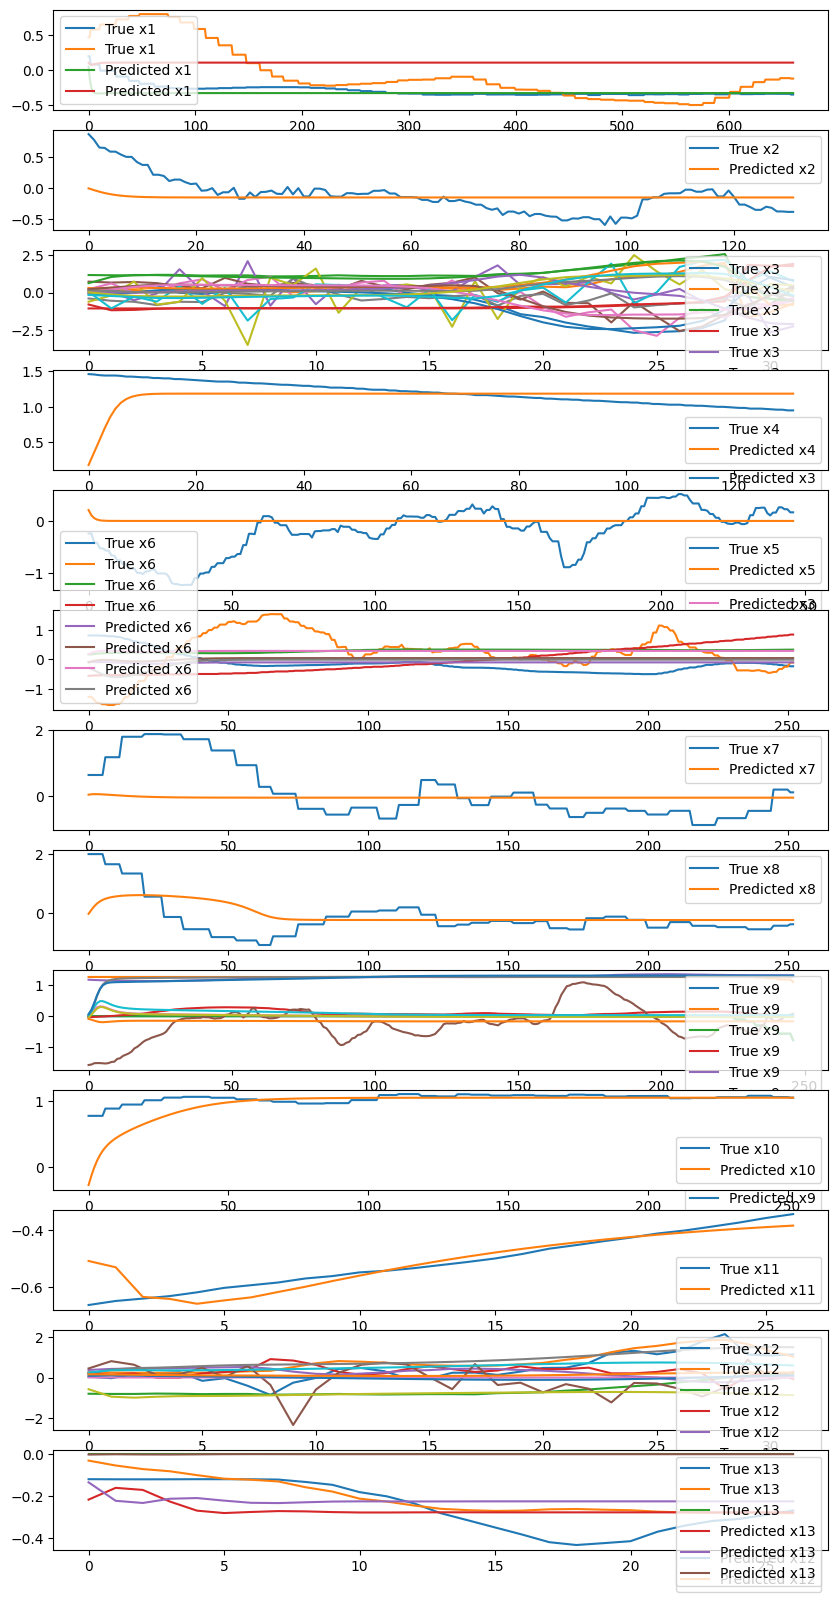

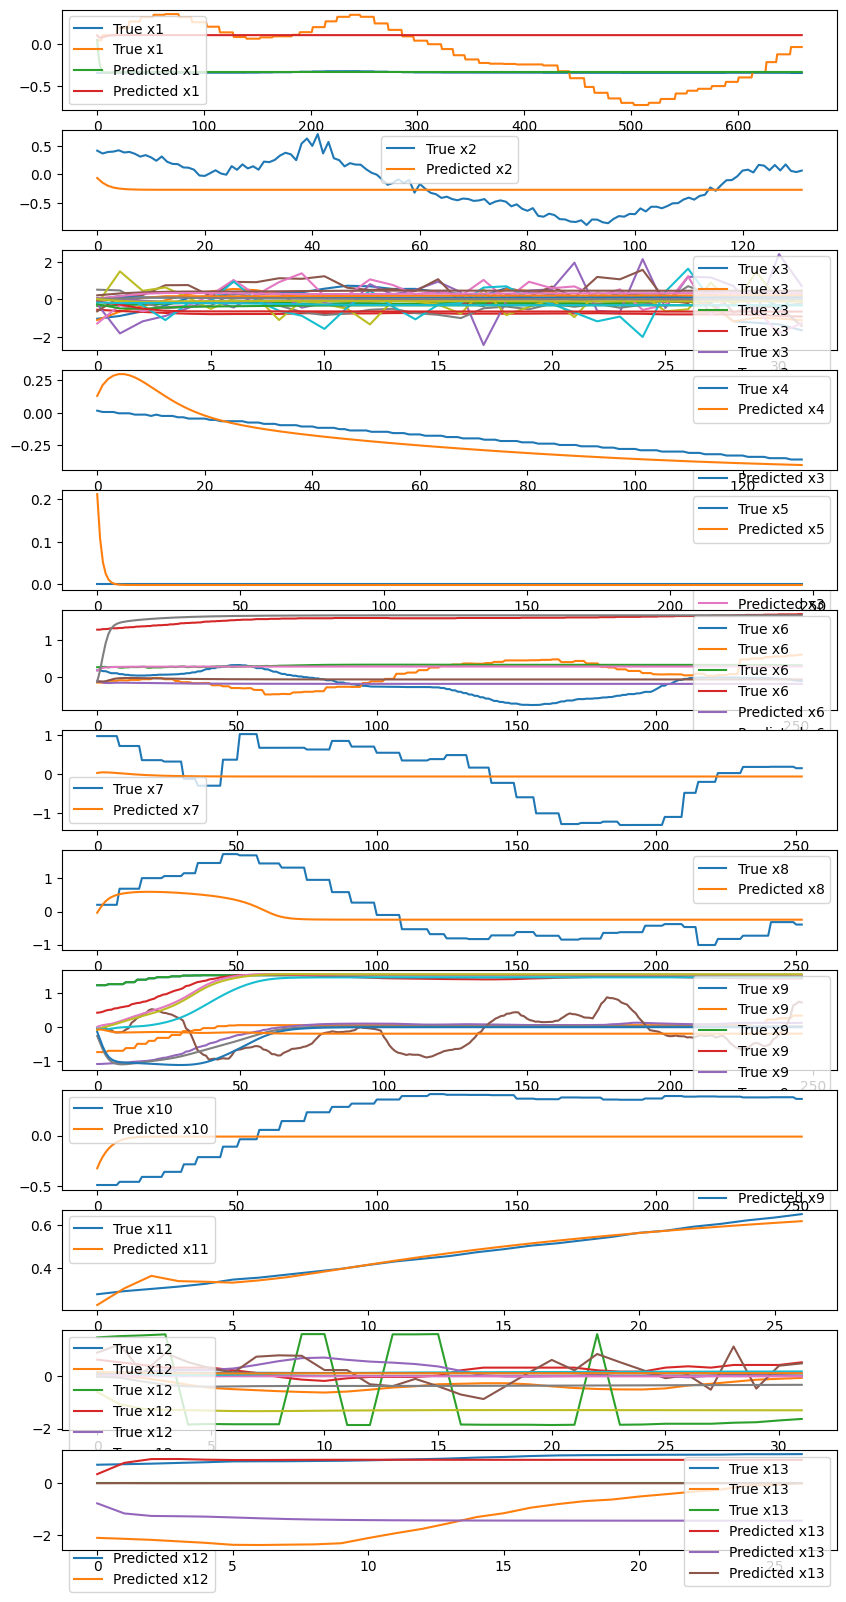

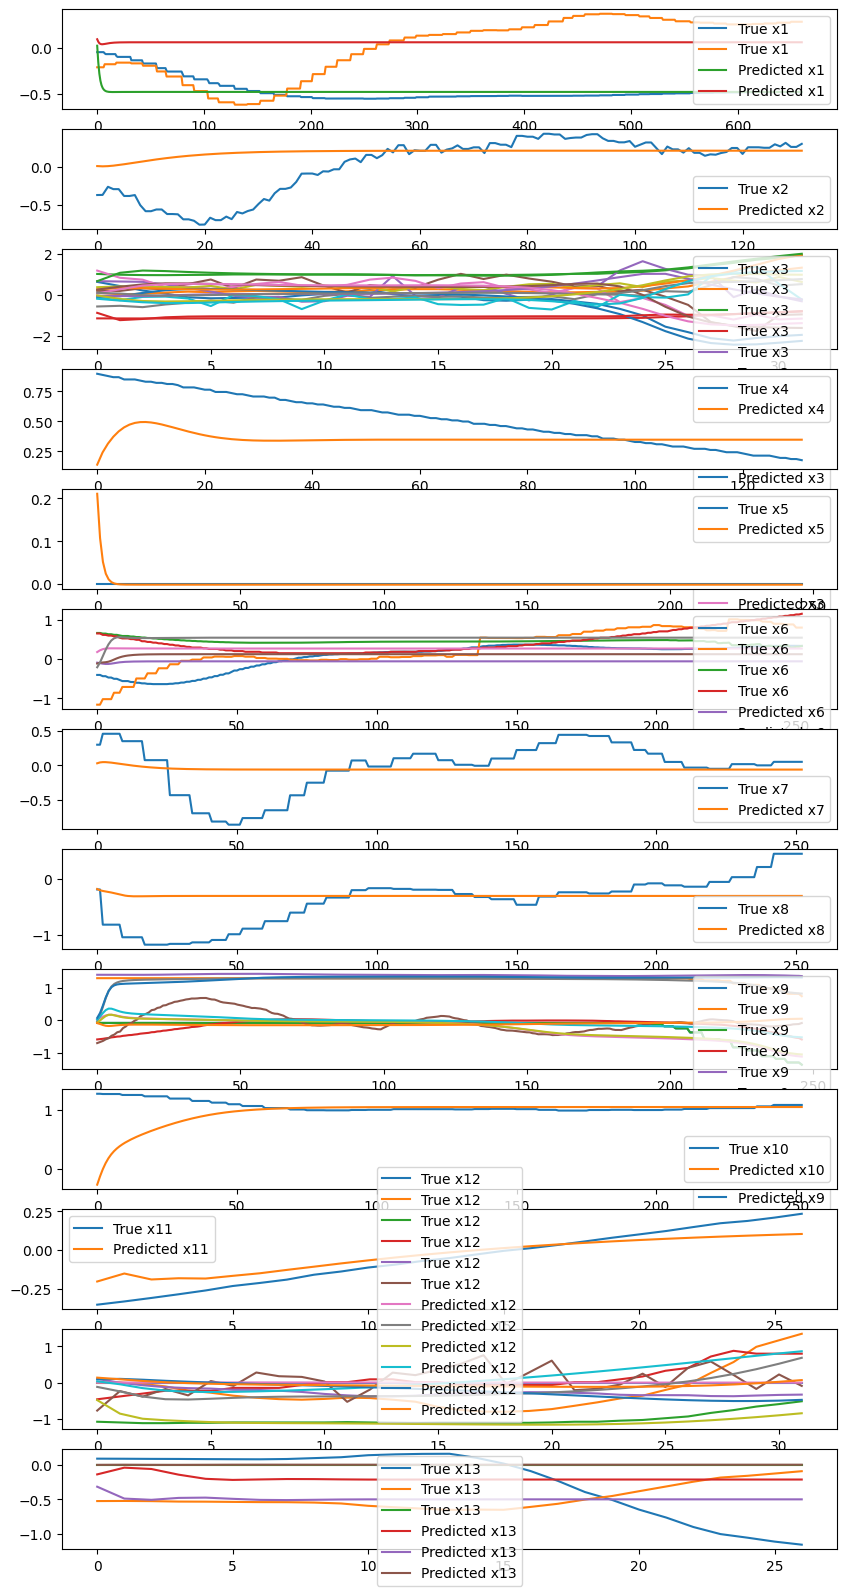

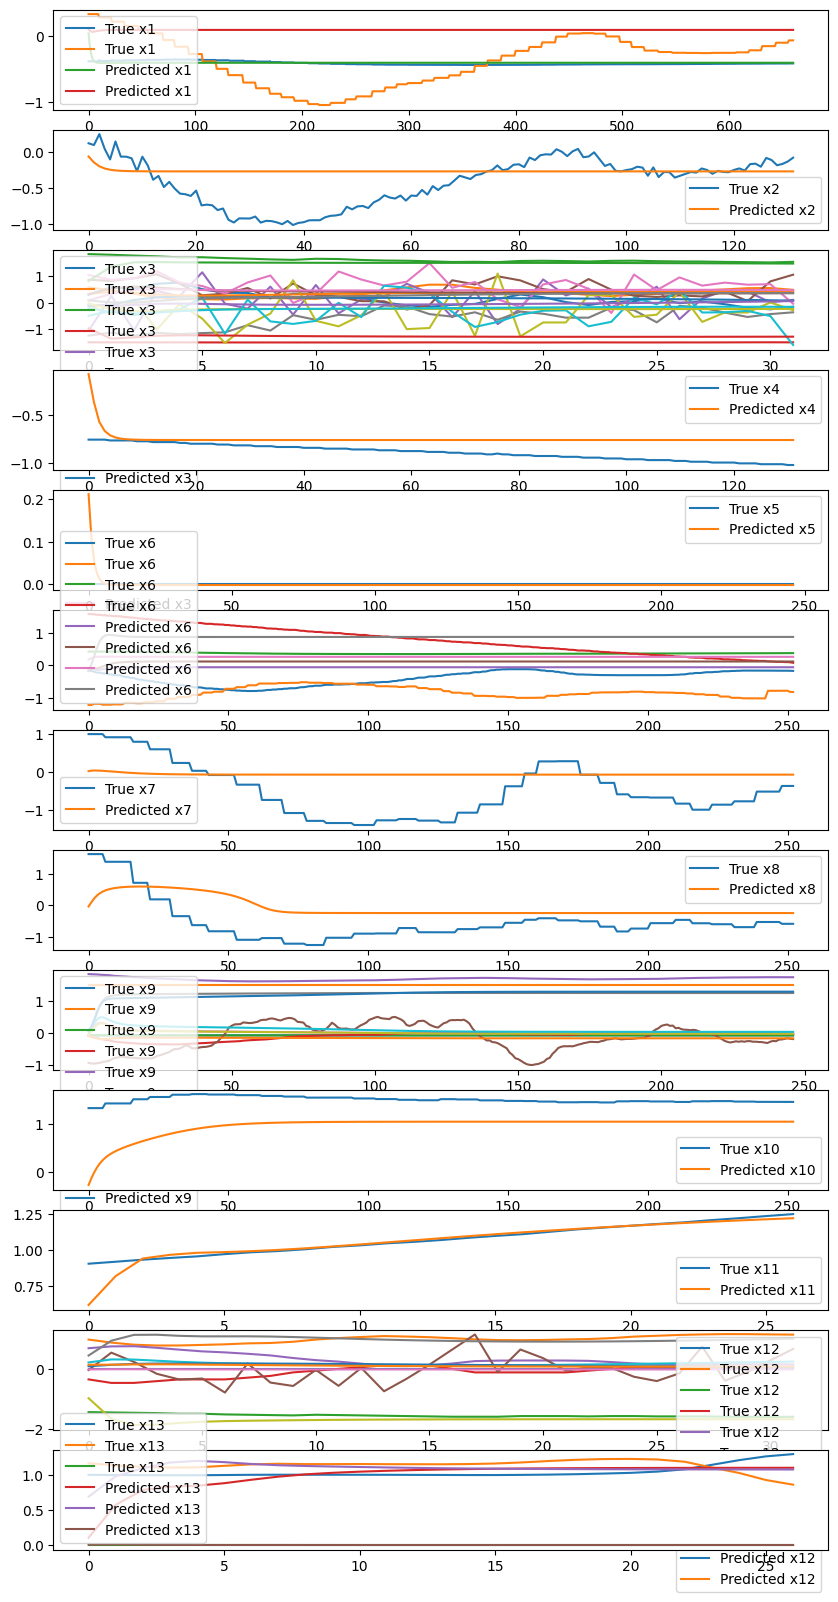

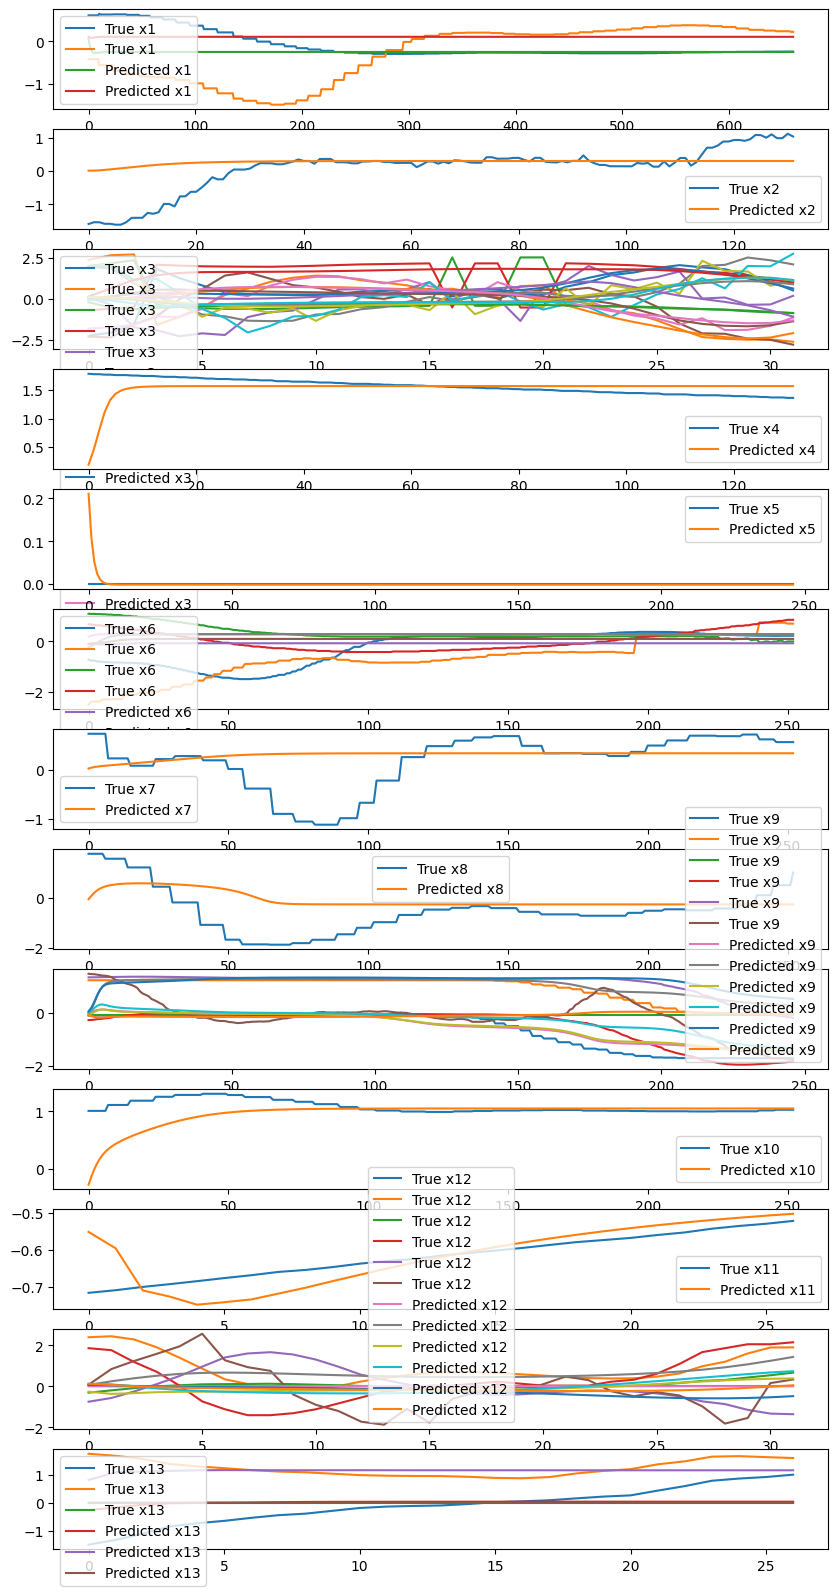

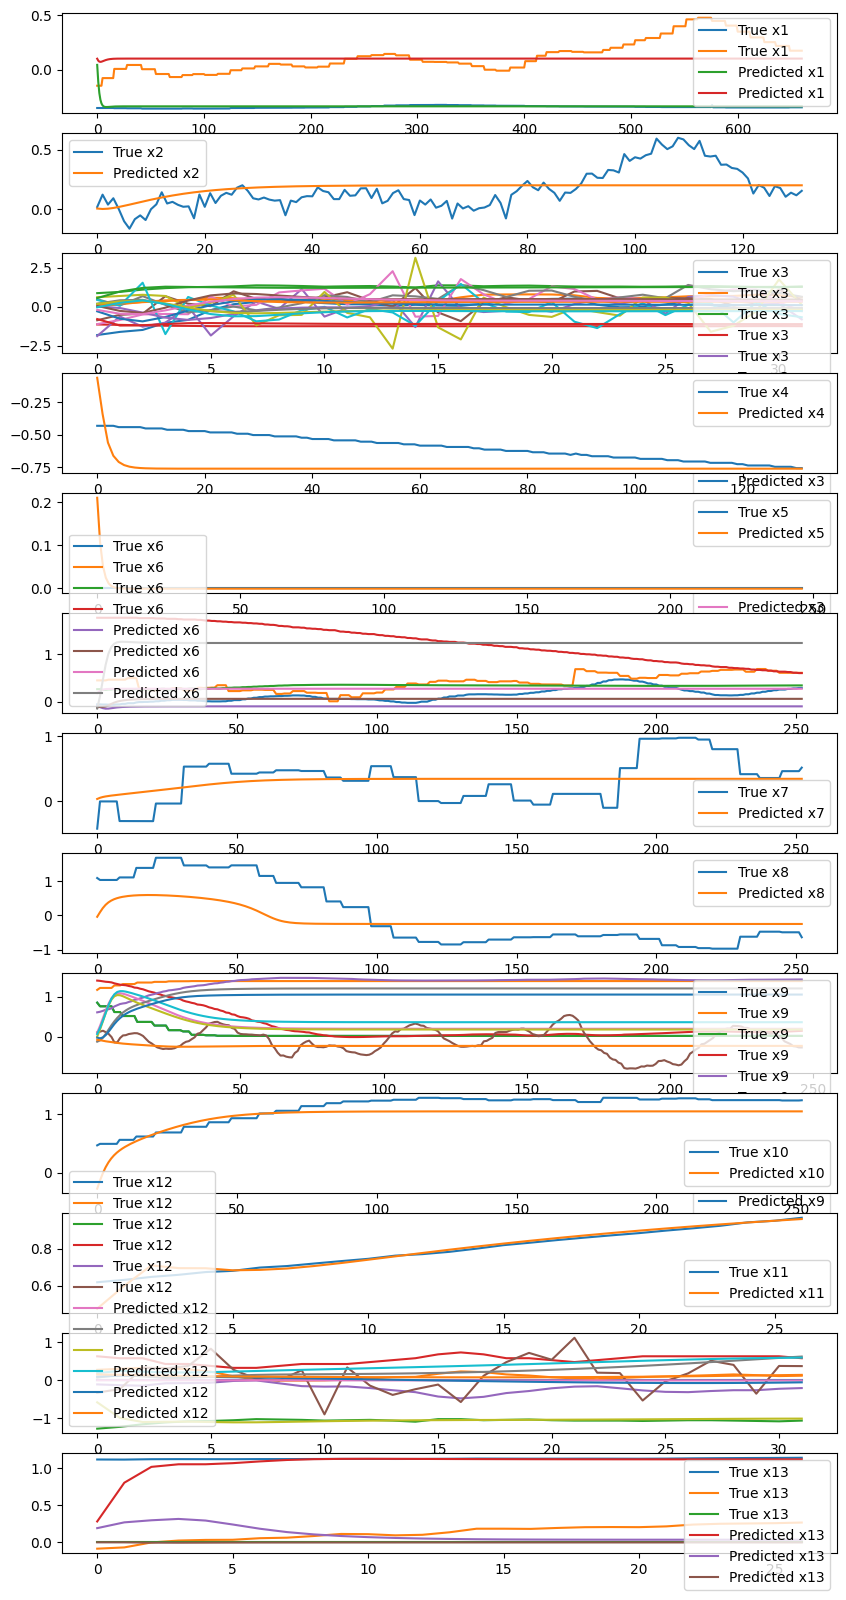

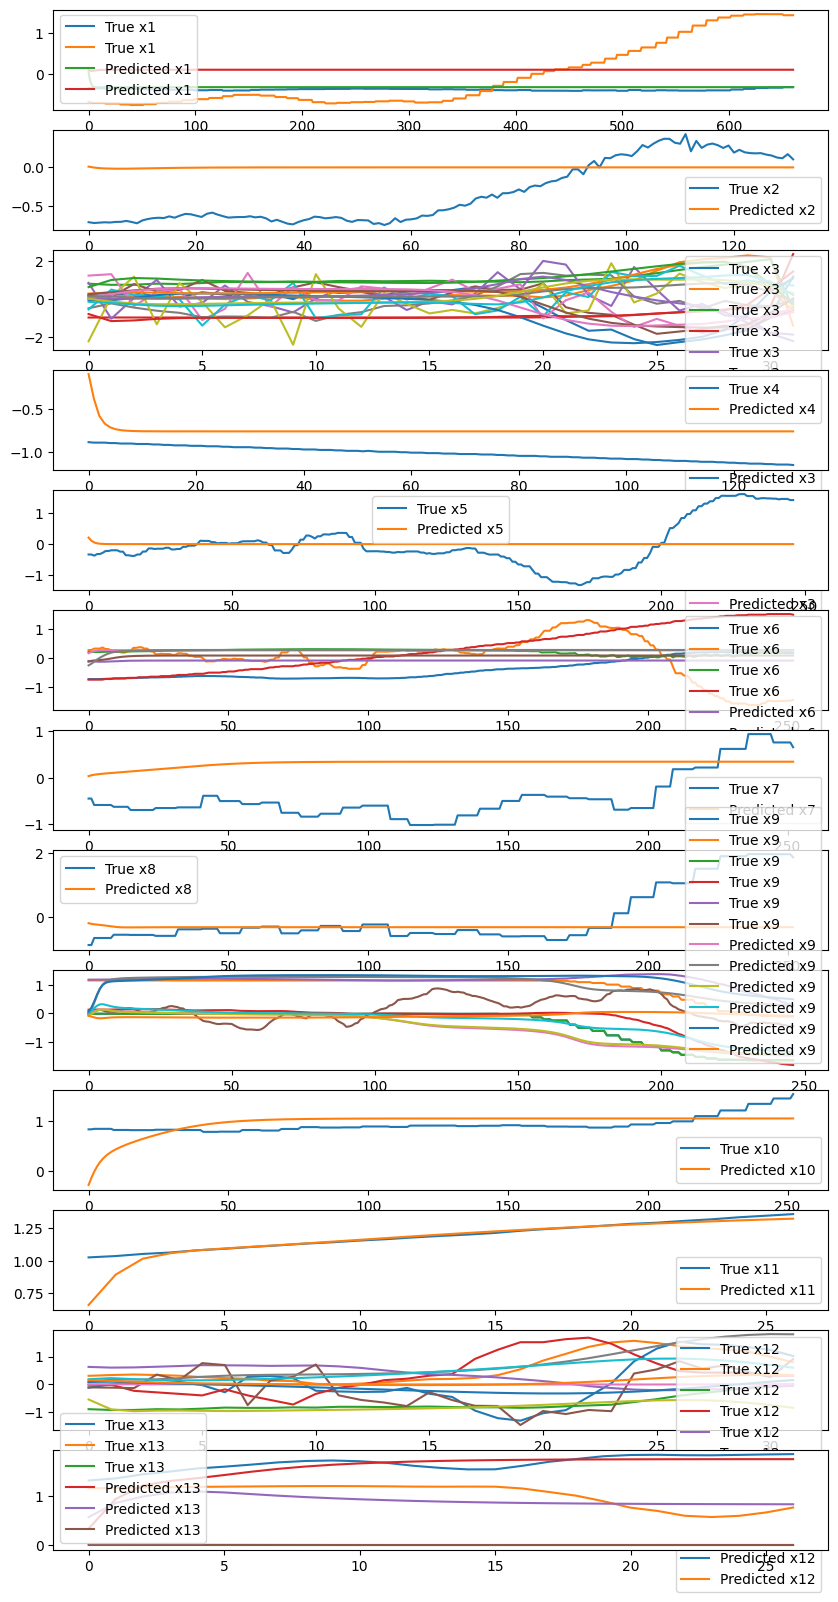

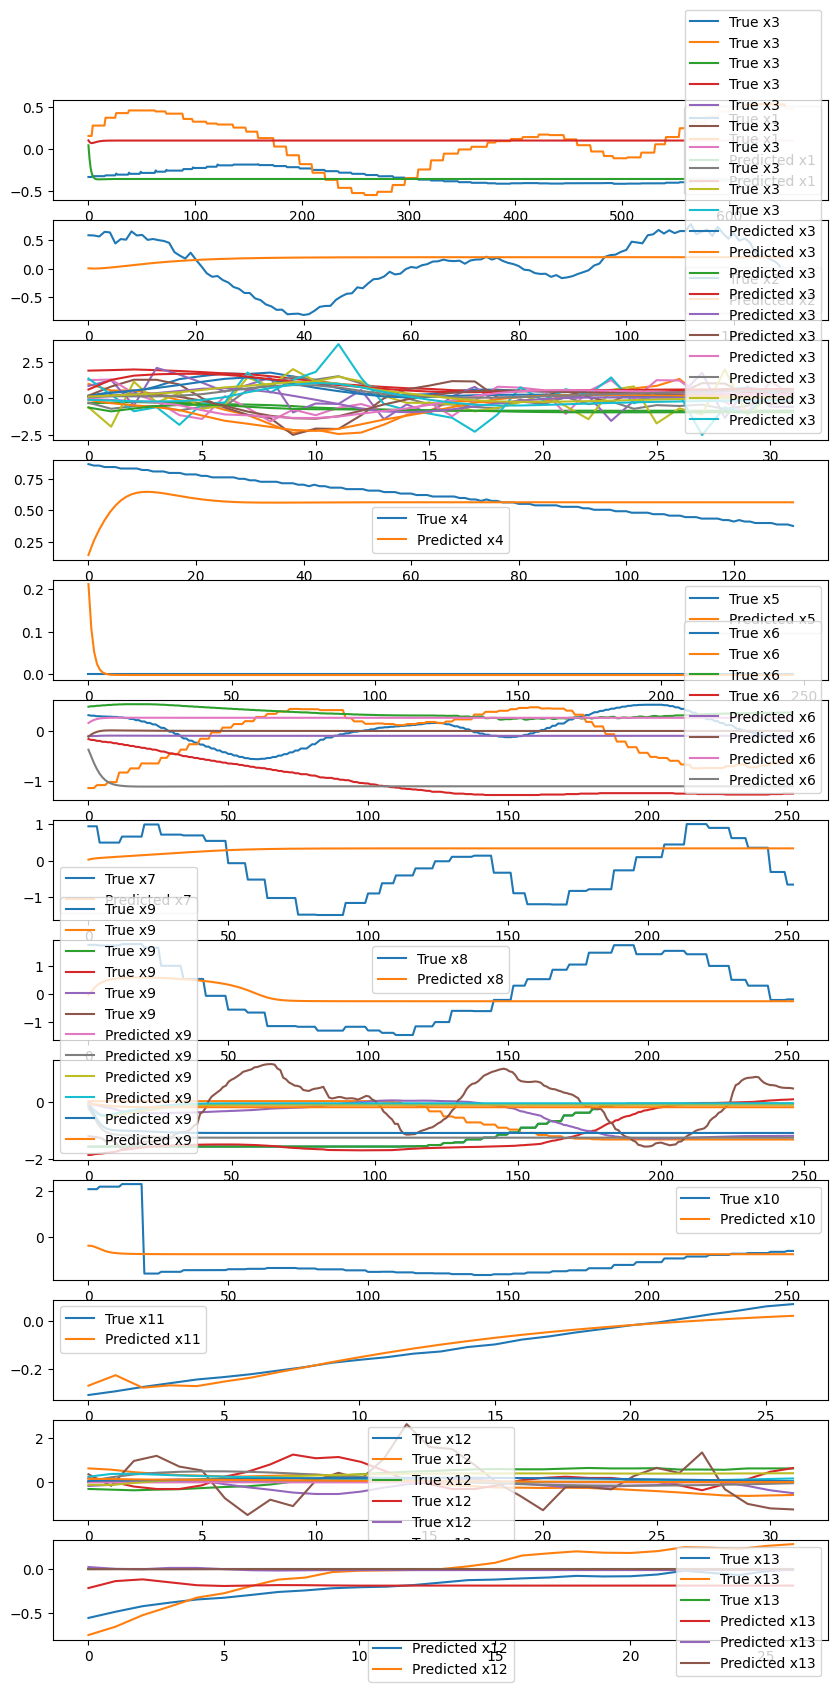

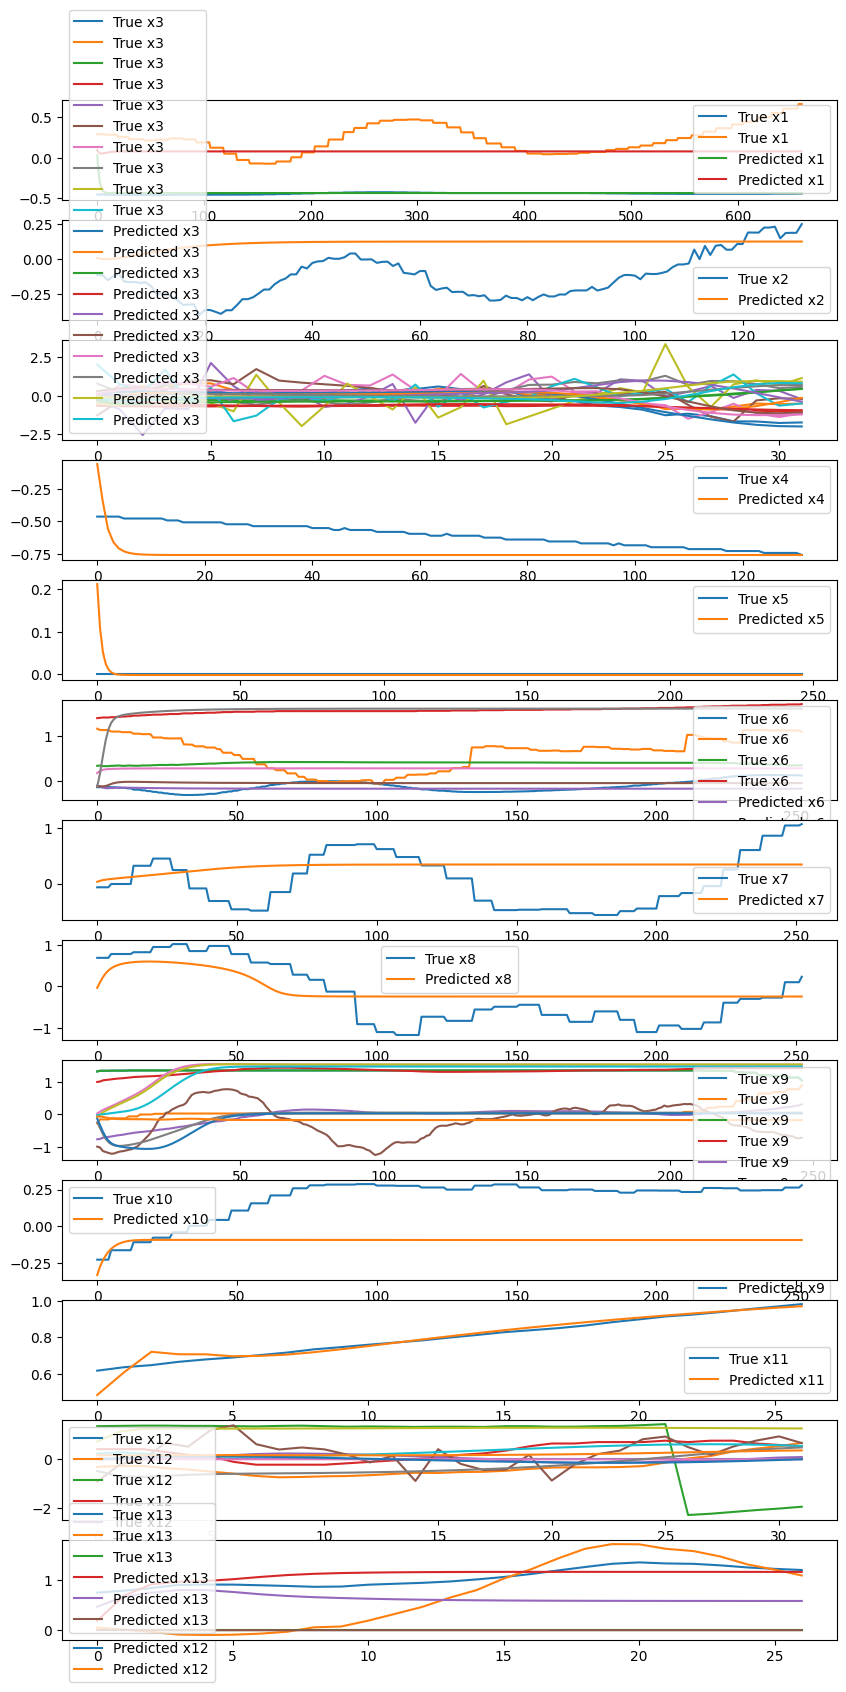

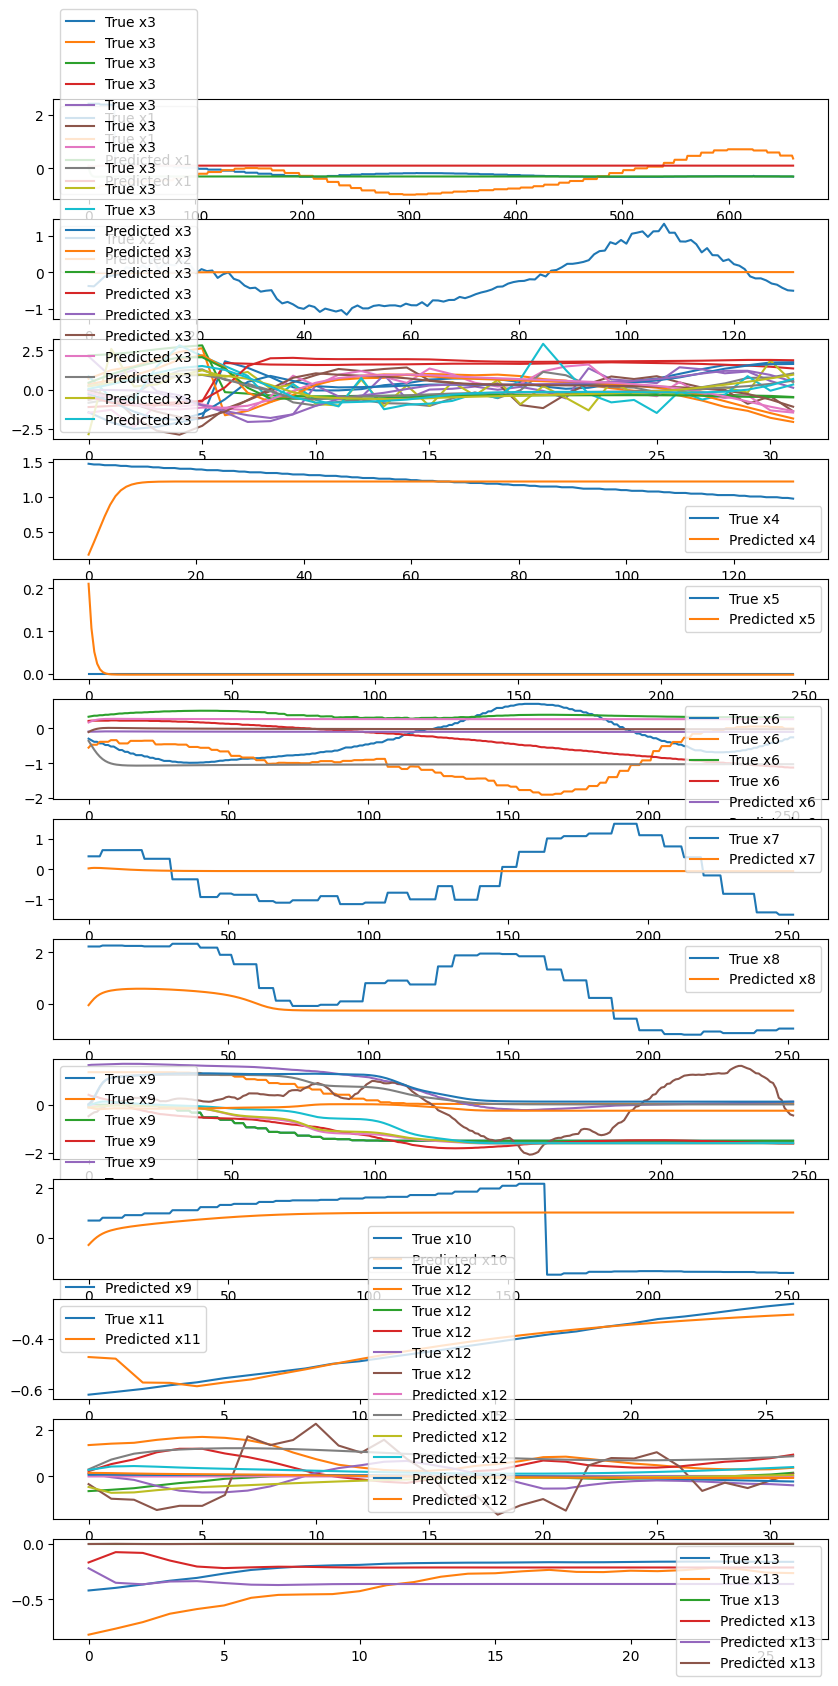

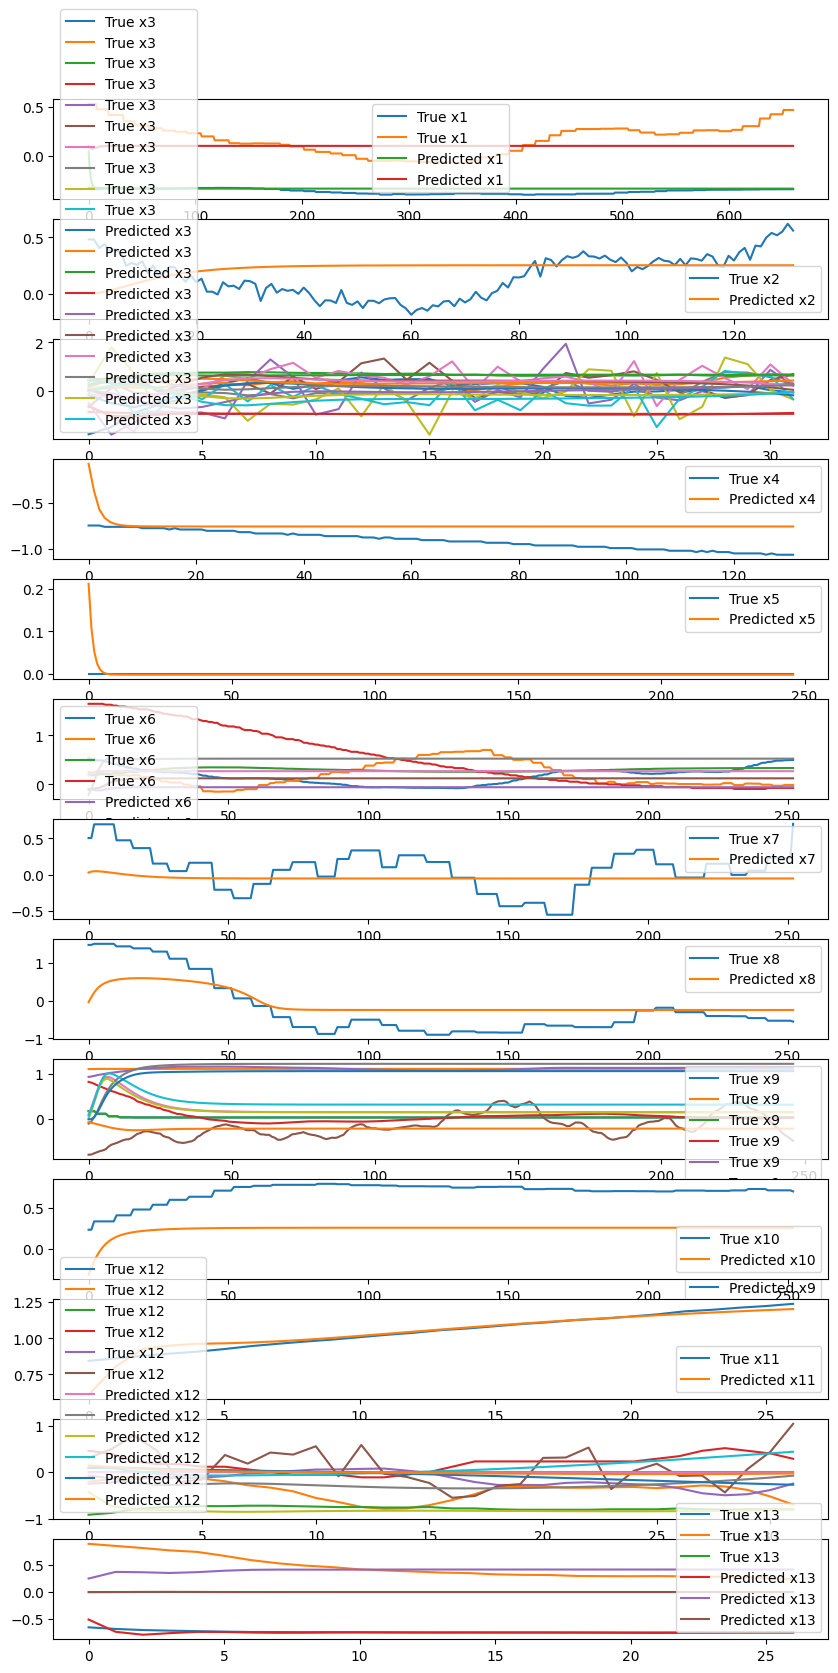

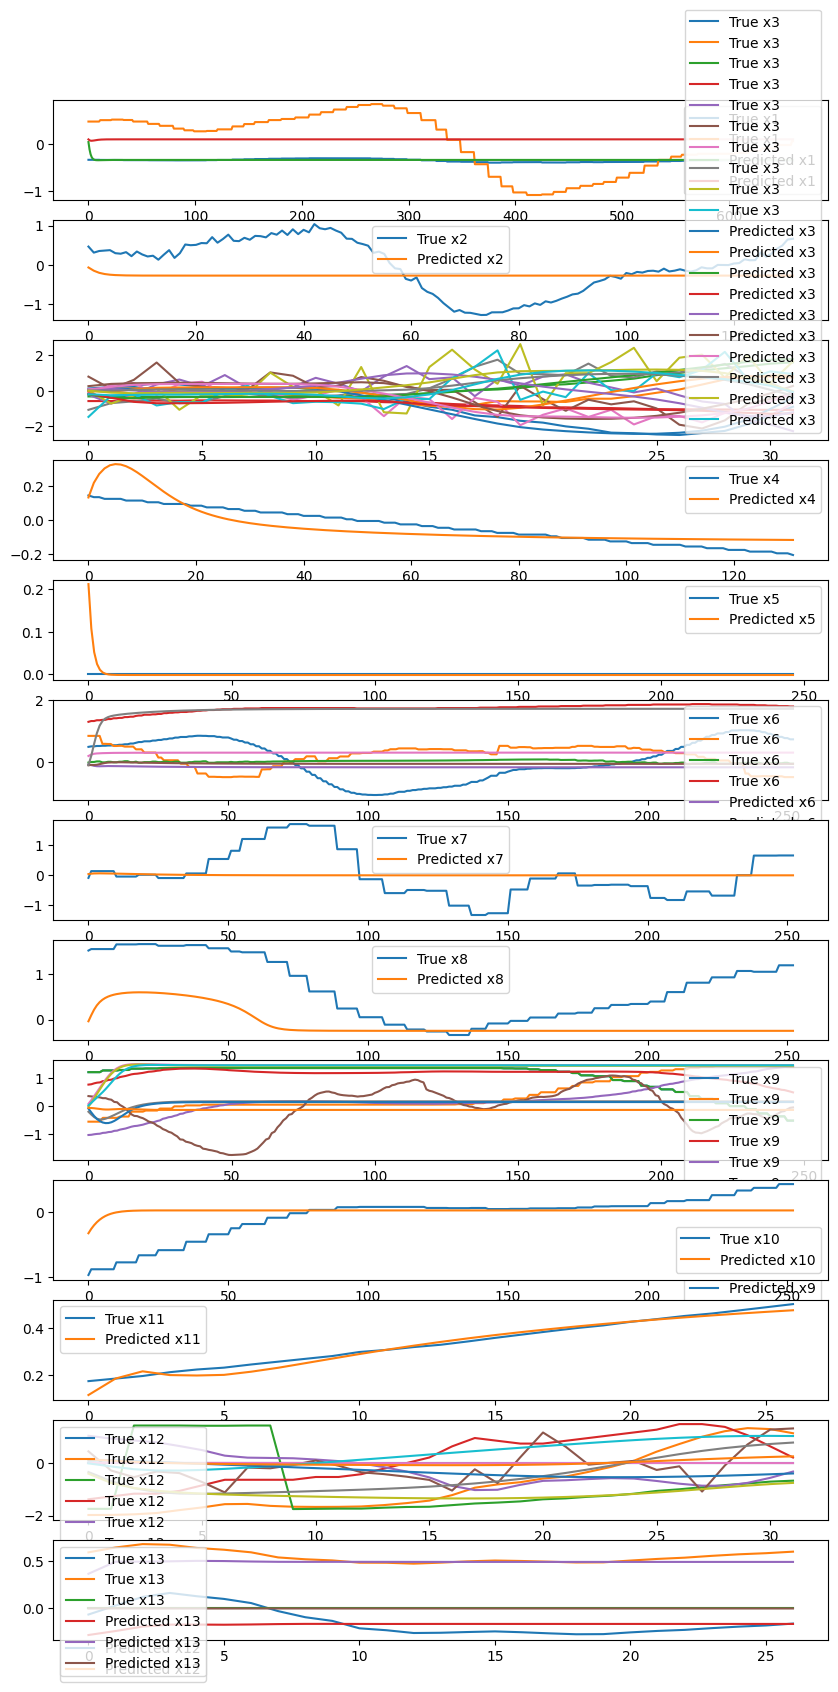

In [121]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def predict_and_plot(model, dataset):
    criterion = nn.MSELoss(reduction='mean').to(device)
    model.eval()
    
    with torch.no_grad():
        for batch_val in dataset:
            batch_val_device = [batch_val[i].to(device) for i in range(len(batch_val))]          
        
            outputs = model(batch_val_device[:-1])
            
            fig, axs = plt.subplots(13, 1, figsize=(10, 20))  # Adjust the height to fit the plots

            # Plot each of the 13 subplots
            for i in range(13):
                axs[i].plot(batch_val[i][0].cpu().numpy(), label=f'True x{i+1}')
                axs[i].plot(outputs[i][0].cpu().numpy(), label=f'Predicted x{i+1}')
                axs[i].legend()
            
          
            plt.show()

# Example usage:
predict_and_plot(model, test_normal_dataloader)
